In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import cv2
from PIL import Image
import os
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
train_image_dir = "test_image_slices/train"
validation_image_dir = "test_image_slices/val"

In [3]:
TRANSFORMATIONS = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225] )
    ])

In [4]:
class CustomDataset(Dataset):
	def __init__(self, image_dir, transforms):
		self.image_dir = image_dir
		self.transforms = transforms
		
		self.image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith(".jpg")]
		
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.image_paths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		image_path = self.image_paths[idx]
		
		# load the image from disk, convert it to grayscale
		image = Image.open(image_path).convert('L')
		
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations
			image = self.transforms(image)
			
		# return a tuple of the images
		return image, image
    

In [5]:
train_dataset = CustomDataset(train_image_dir, TRANSFORMATIONS)
test_dataset = CustomDataset(validation_image_dir, TRANSFORMATIONS)

In [6]:
# Configurations

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

BATCH_SIZE = 16

In [7]:
torch.cuda.is_available()

True

In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=PIN_MEMORY, num_workers=0)

In [9]:
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=PIN_MEMORY, num_workers=0)

In [10]:
images = next(iter(train_loader))

In [11]:
np_images = np.array(images)

In [12]:
np_images.shape

(2, 8, 1, 288, 256)

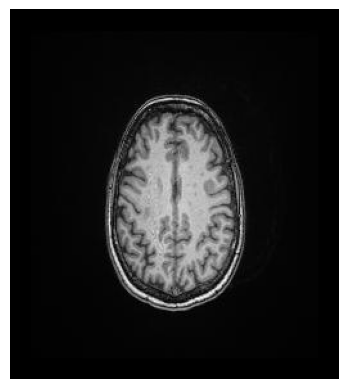

In [13]:
# plot grid TODO

plt.imshow(images[0][16], cmap='gray')
plt.axis("off")
plt.show()

In [12]:
# unet model

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        
        # Contracting Path
        self.conv1 = self.conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = self.conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.conv5 = self.conv_block(512, 1024)
        
        # Expansive Path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = self.conv_block(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = self.conv_block(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = self.conv_block(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = self.conv_block(128, 64)
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Contracting Path
        conv1 = self.conv1(x)
        pool1 = self.pool1(conv1)
        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)
        conv3 = self.conv3(pool2)
        pool3 = self.pool3(conv3)
        conv4 = self.conv4(pool3)
        pool4 = self.pool4(conv4)
        conv5 = self.conv5(pool4)
        
        # Expansive Path
        up6 = self.up6(conv5)
        up6 = torch.cat([up6, conv4], dim=1)
        conv6 = self.conv6(up6)
        up7 = self.up7(conv6)
        up7 = torch.cat([up7, conv3], dim=1)
        conv7 = self.conv7(up7)
        up8 = self.up8(conv7)
        up8 = torch.cat([up8, conv2], dim=1)
        conv8 = self.conv8(up8)
        up9 = self.up9(conv8)
        up9 = torch.cat([up9, conv1], dim=1)
        conv9 = self.conv9(up9)
        out = self.conv10(conv9)
        
        return out

In [13]:
model = UNet()
model = model.to(DEVICE)

In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

In [15]:
epochs = 300

In [16]:
# Training loop

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss}, Val Loss: {val_loss}')



  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [1/300], Train Loss: 0.03529847755915724, Val Loss: 0.02793811944623788


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [2/300], Train Loss: 0.0006997281472463934, Val Loss: 0.002926687270195948


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [3/300], Train Loss: 0.00041306529164562237, Val Loss: 0.0010631514144026572


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [4/300], Train Loss: 0.00026710550615242494, Val Loss: 0.0003164946376475402


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [5/300], Train Loss: 0.0002827309600031436, Val Loss: 0.0019842503566501867


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [6/300], Train Loss: 0.00027027259426351476, Val Loss: 0.00017149577696626593


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [7/300], Train Loss: 0.00019018516234077526, Val Loss: 0.00015826123368848735


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [8/300], Train Loss: 0.0002224060869253105, Val Loss: 0.00019712264151571112


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [9/300], Train Loss: 0.00013884113097401918, Val Loss: 0.0004542902784629001


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [10/300], Train Loss: 0.0001530741189270217, Val Loss: 8.190650664295795e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [11/300], Train Loss: 0.00011618926408614145, Val Loss: 6.741387712989106e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [12/300], Train Loss: 0.00017518921573783327, Val Loss: 0.00034516507002990693


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [13/300], Train Loss: 0.0001662879677544544, Val Loss: 0.0006037395344012313


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [14/300], Train Loss: 0.00016543057140960552, Val Loss: 0.00011984003261507799


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [15/300], Train Loss: 0.00014762200977207787, Val Loss: 0.0006739325860204796


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [16/300], Train Loss: 0.00012274927485967776, Val Loss: 0.0005964035937924766


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [17/300], Train Loss: 0.00013112735623874394, Val Loss: 8.526080313863026e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [18/300], Train Loss: 0.00017953678021631305, Val Loss: 0.00014692166183117984


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [19/300], Train Loss: 0.0001031769925783224, Val Loss: 3.5788687051131594e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [20/300], Train Loss: 0.0001108911958517328, Val Loss: 0.00020182895564681126


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [21/300], Train Loss: 7.565162445010542e-05, Val Loss: 3.5505068606451256e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [22/300], Train Loss: 0.00020433555360041536, Val Loss: 3.23228072779279e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [23/300], Train Loss: 0.0001919545125709659, Val Loss: 0.0006685686465870175


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [24/300], Train Loss: 0.00010905812037445536, Val Loss: 0.00018888319512673965


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [25/300], Train Loss: 0.0001277342676934743, Val Loss: 0.0002936380769824609


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [26/300], Train Loss: 0.00012406407103617172, Val Loss: 0.00039145876427129324


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [27/300], Train Loss: 0.00012183102346407451, Val Loss: 5.045847339917802e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [28/300], Train Loss: 0.00012361234318516894, Val Loss: 4.322741531521185e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [29/300], Train Loss: 0.00011994866236190862, Val Loss: 0.00019361428470195582


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [30/300], Train Loss: 0.00012499007430009042, Val Loss: 5.684474348931367e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [31/300], Train Loss: 8.35028486023585e-05, Val Loss: 9.541957964150545e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [32/300], Train Loss: 0.00011649301725053359, Val Loss: 0.00019969866358830282


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [33/300], Train Loss: 9.914878992783338e-05, Val Loss: 0.00020624439962880893


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [34/300], Train Loss: 0.00011743358358014201, Val Loss: 9.70364304117134e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [35/300], Train Loss: 0.00013333334035712984, Val Loss: 3.316808377146824e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [36/300], Train Loss: 0.00014975392148828555, Val Loss: 0.0003141006713526116


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [37/300], Train Loss: 0.00010204362667365008, Val Loss: 6.420882709790021e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [38/300], Train Loss: 0.00015849065112711244, Val Loss: 0.0016453578654262754


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [39/300], Train Loss: 0.00014529347667707008, Val Loss: 0.00010795485124819809


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [40/300], Train Loss: 0.000253240275575171, Val Loss: 0.00013239421564826948


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [41/300], Train Loss: 0.0002130946485755854, Val Loss: 0.0008245721368843482


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [42/300], Train Loss: 0.00010281145225218483, Val Loss: 5.1337909907387155e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [43/300], Train Loss: 8.459710496212515e-05, Val Loss: 2.4206824996832034e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [44/300], Train Loss: 0.00013648723233646162, Val Loss: 4.975189424132825e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [45/300], Train Loss: 9.402412263065253e-05, Val Loss: 0.0001337090337377352


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [46/300], Train Loss: 9.194515869999953e-05, Val Loss: 3.2577329976548855e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [47/300], Train Loss: 7.15874039172267e-05, Val Loss: 2.3325636195497485e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [48/300], Train Loss: 0.0001228256464194097, Val Loss: 0.00025526052922941744


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [49/300], Train Loss: 0.00011287973867513054, Val Loss: 0.00011010250374157395


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [50/300], Train Loss: 0.00013781086555768624, Val Loss: 6.79343809477157e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [51/300], Train Loss: 9.693697200069527e-05, Val Loss: 4.112852810875564e-05


  0%|          | 0/21 [00:00<?, ?it/s]         

Epoch [52/300], Train Loss: 0.00011097636969829261, Val Loss: 3.886273285994927e-05


 57%|█████▋    | 12/21 [00:13<00:10,  0.88it/s]

KeyboardInterrupt: 